<a target="_blank" href="https://colab.research.google.com/github/AshishKumar4/FlaxDiff/blob/main/tutorial%20notebooks/simple%20diffusion%20flax.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Basics of Diffusion based generative models from Scratch

**Please bear with me at times and read through the entire notebook thoroughly.** I have tried to explain the concepts in the simplest way possible but some concepts are inherently complex and require a bit of mathematical understanding. I have tried to simplify the math as much as possible and have provided links to the original papers for further reading.

## Diffusion and Score Based Models

### Introduction

In recent years, several methods have arisen for generative modeling of data such as Variational Autoencoders (VAEs), Generative Adversarial Networks (GANs), Autoregressive models, and Normalizing Flows just to name a few. But none really broke the internet quite like the way diffusion models did. Reason being, none could generate images with the same level of quality and diversity as diffusion models. GANs did come close but they were really painful to train and were really unstable. Autoregressive models were too slow. Normalizing Flows were too computationally expensive. VAEs were too blurry. 

### The Idea

The idea was that trying to train a model to generate an image in a single step was too hard, so why not instead let it model it in multiple steps? There were two approaches that were proposed to do this: Score based models and diffusion models. But in both, the idea was that our data could be thought of as a special complicated distribution that we could sample from, and that we could start from a simple distribution such as a normal distribution and find a way to transform samples from this simple distribution into those from the data distribution (or as close as we can get). 

Therefore, its a problem of going from a random high entropy point in the input space to a low entropy point where the scale of entropy is defined as a continous mapping from the data distribution to the simple normal distribution.

Thus we would start from a random sample from normal distribution aka some random gaussian noise, and iteratively try to find our way to gradually transform it into some sample that looks like it came from the data distribution. We do this in some defined time steps $t$. Thus we define a process of starting from a random noise sample at time $t=0$ and gradually removing the noise and finding some useful data at each time step $t$ until we reach $t=T$ where we have ideally no noise and only data left.

### How do we do this?

#### Score Based Models

The score based models tackle this by trying to estimate the gradient of the log-likelihood of the data distribution (don't get scared, just bear it for now) at each time step. This gradient basically points us in the direction of the data distribution from the current sample, and we can then take a step in that direction to remove some noise in kind of like a gradient decent style process. This process is repeated until we reach the final time step where we have ideally no noise left. This is the basic idea behind score based models. The noising and denoising processes are defined by stochastic differential equations (SDEs). We will learn about these formulations in later sections.

#### Diffusion Models

The way diffusion models work is by simply training a model that, given an intermediate noised sample, try to denoise the sample a bit at each discrete time step in an image-to-image manner rather than explicitly learning to estimate the gradient. The time step itself can also be provided to the model to assist it in the process. It has been shown that both score based and diffusion principles are equivalent, they only really differ in the way their objective loss functions are defined. 

In the original DDPM paper, diffusion processes were defined as a markov chain where in forward time, we would go from a sample $x_t$ with some amount of noise to a sample $x_{t+1}$ with more noise, and the reverse of this in reverse time, in discrete time steps $t$. This has been cited as the only major difference between score based models and diffusion models but if you think about it, they are basically the same thing. In discrete time steps, we have markov chains of states of DDPM, in continuous time steps (i.e, infinitesimal time steps), we have stochastic differential equations (SDEs) of score based models.

And thus, more recent papers use the more generalized approach of formulating the processes as SDEs and ODEs as finding solutions i.e, integrating differential equations is a very well studied field with several solvers available.

But we need to train the model as well right? and what exactly is this diffusion process? Well its pretty intuitive from what we have understood so far: We can simply take samples from our actual data distribution, and construct a set of samples with gradually increasing noise levels by adding gaussian noise at each time step, until we basically have a set of samples that are just noise. This gradual noising process is very similar to the process of diffusion from thermodynamics where particles move from low entropy to high entropy, hence the name. Score based models just stumbled upon the same idea independently.

## The Diffusion Process

The diffusion process (the forward diffusion process) can be described as a stochastic differential equation (SDE):

$dx_t = f(t, x_t) \, dt + g(t, x_t) \, dW_t $

where:
- $dx_t$ is the infinitesimal change in the data sample $x_t$ at time $t$,
- $f(t, x_t)$ is the drift term, which represents the deterministic part of the process,
- $g(t, x_t)$ is the diffusion term, which represents the stochastic part of the process,
- $dW_t$ is the infinitesimal increment of a Wiener process (or standard Brownian motion).

Don't get overwhelmed by the math, its just a fancy way of saying that the data sample at time $t$ is a function of the data sample at time $t-1$ and some noise. The drift term is the deterministic part of the process that tells us how the data sample changes over time, and the diffusion term is the stochastic part that tells us how the noise affects the data sample. We would soon look at how we can model these terms in the form of a defined noise schedule.

Given the above forward-time diffusion process SDE, We can also formulate the reverse-time diffusion process SDE (as found by Anderson (1982)):

$dx_t = [f(t, x_t) - g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t)] \, dt + g(t, x_t) \, d\bar{W}_t $

where:
- $ dx_t $ is the infinitesimal change in the data sample $ x_t $ at time $ t $,
- $ f(t, x_t) $ is the drift term from the forward process,
- $ g(t, x_t) $ is the diffusion term from the forward process,
- $ \nabla_{x_t} \log p_t(x_t) $ is the gradient of the log-density of the data at time $ t $,
- $ d\bar{W}_t $ is the infinitesimal increment of a reverse-time Wiener process (or standard Brownian motion).

Again, its nothing fancy and quite easy to understand when we will later try implementing these.

We will thus implement our forward diffusion process via a Noise schedule and our reverse diffusion process via a Sampler, which is essentially a SDE (or ODE) solver that finds a solution to the above differential equation.

An important thing to note is that Every reverse-time diffusion SDE has a corresponding probability flow ODE with the same marginal densities. This essentially means that we can find solutions to go from a noised sample to a denoised sample in a deterministic manner following an ODE as well. This is the difference between ancestral (like DDPM, Euler-A) and non anscestral samplers (like DDIM, Euler etc). Ancestral samplers solve the SDE, while non-ancestral samplers solve the ODE. The Probability Flow ODE is given by:

$ \frac{dx_t}{dt} = f(t, x_t) - \frac{1}{2} g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t) $

where:
- $\frac{dx_t}{dt}$ is the time derivative of the data sample $x_t$,
- $f(t, x_t)$ is the drift term from the forward process,
- $g(t, x_t)$ is the diffusion term from the forward process,
- $\nabla_{x_t} \log p_t(x_t)$ is the gradient of the log-density of the data at time $t$.

This ODE provides a deterministic trajectory that samples from the same distribution as the original stochastic process.

If we try to model this term $\nabla_{x_t} \log p_t(x_t)$ directly as a neural network $s_t(x_t)$, we get what is known as a score based model. But if we try to think of it as a kind of noise term $ \frac{\epsilon_{\theta}(x_t, t)}{\sigma_t} $, we get a diffusion model. Both of these are equivalent but just for brevity, we shall discuss what the original DDPM paper did.

### DDPM's original formulation for Diffusion

The DDPM paper defined the forward diffusion process as a markov chain of conditional distributions $q(x_t|x_{t−1})$:

$q(x_t|x_{t−1}) := \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t−1}, \beta_t I)$

where:
- $x_t$ is the data sample at time $t$,
- $x_{t−1}$ is the data sample at time $t-1$,
- $\beta_t$ is the noise level at time $t$,
- $I$ is the identity matrix.

And the reverse diffusion process was defined as:

$p_\theta(x_{t−1}|x_t) := \mathcal{N}(x_{t−1};\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$

where:
- $x_{t−1}$ is the data sample at time $t-1$,
- $x_t$ is the data sample at time $t$,
- $\mu_\theta(x_t, t)$ is the mean of the reverse distribution,
- $\Sigma_\theta(x_t, t)$ is the covariance of the reverse distribution.

The noise level $\beta_t$ was defined as a function of time $t$ and the number of time steps $T$ and the $\mu_\theta(x_t, t)$ was basically our neural network that we would train to denoise the sample at time $t$, with the wights being $\theta$.

But remember that this is just a discretized version of the diffusion differential equations we discussed above, and latest research papers use the more generalized version formulated as the SDEs and ODEs rather than the markov chain. But just for the sake of accuracy, we shall implement DDPM and DDIM with this markov chain formulation.

These are basically defined via noise schedules in FlaxDiff and thus using a discretized noise schedule vs a continuous one is what differentiates DDPM/DDIM from the latest techniques (and also score based methods but along with the loss function which is just slightly different).

You can read more about the generalization of the diffusion process in the paper [Score based generative modeling through stochastic differential equations](https://arxiv.org/pdf/2011.13456)

## The Intuition

Now that we have formulated all the maths in the previous sections, let's try to build the intuition of what we are trying to do. As we discussed briefly in the [The Idea](#the-idea) section, Every image (or data sample) can be thought of as a point in a high dimensional space. For example, a 64x64 image is basically an array of 64x64x3=12288 pixels. If you treat this array as a vector, its a vector in a 12288 dimensional space. Now, its hard for our monkey brains to imagine anything beyond a 4D space, let alone a 12288D one, but bear with me. A noisy image is thus also a similar point in this same high dimensional space.

Now, in the forward diffusion process, all we are doing is trying to go from the point of low entropy i.e, the data sample (image) $x_0$ to a point of high entropy i.e, a complete noise sample $\epsilon_0$. Every point we encounter along the trajectory we take is our intermediate noisy image $x_t$. Here is a simple visualization of the process:

<img src="../images/output.png" width="50%" height="50%"/>

The denoising diffusion model that we would train (or the score based model, depending on the formulation) is what guides us along the trajectory of the reverse diffusion process. It shows the way (the direction) from any noisy image towards a cleaner image sample. The samplers then take steps along this direction to reach the final denoised image. In the above visualization, the green curve does not truly represent the reverse path though because it can be that our denoising model takes us on a different path towards a different image in the vicinity of the starting noise, but it would be a clean image of low entropy nonetheless.

# Install Dependencies

**You must install a proper version of tensorflow and jax, and setup gpu for this notebook to work. Go through the official tensorflow installation steps**

**The notebook only works for jax version 0.4.28**

In [1]:
!pip install jax[cuda12]==0.4.28 flax[all] orbax clu tensorflow-datasets

DEPRECATION: Loading egg at /home/mrwhite0racle/miniconda3/envs/flax/lib/python3.12/site-packages/flash_attn_jax-0.2.2-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


# Imports

In [2]:
import tqdm
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
from flax.training import orbax_utils
import functools
import numpy as np

2024-07-25 00:05:59.271074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 00:05:59.280042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 00:05:59.282745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 00:05:59.707374: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Some Important Utils

In [3]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

class RandomClass():
    def __init__(self, rng: jax.random.PRNGKey):
        self.rng = rng

    def get_random_key(self):
        self.rng, subkey = jax.random.split(self.rng)
        return subkey
    
    def get_sigmas(self, steps):
        return jnp.tan(self.theta_min + steps * (self.theta_max - self.theta_min)) / self.kappa

    def reset_random_key(self):
        self.rng = jax.random.PRNGKey(42)

class MarkovState(struct.PyTreeNode):
    pass

class RandomMarkovState(MarkovState):
    rng: jax.random.PRNGKey

    def get_random_key(self):
        rng, subkey = jax.random.split(self.rng)
        return RandomMarkovState(rng), subkey

# Data Pipeline

For simplicity, we will use the oxford flowers dataset for this notebook. We will use the tensorflow datasets library to load the dataset. 

**Note that if you are having issues with the tensorflow datasets library, in the other tutorial notebooks, we have provided an alternative way to load the dataset using google/grain library.**

In [4]:
def get_dataset(data_name="oxford_flowers102", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], tf.float32) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_contrast(image, 0.999, 1.05)
            image = tf.image.random_brightness(image, 0.2)

            image = tf.clip_by_value(image, -1.0, 1.0)
            return image
        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        .cache()  # Cache after augmenting to avoid recomputation
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .repeat()  # Repeats the dataset indefinitely
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    ).as_numpy_iterator()
    return final_data, len(data)


# Noise Schedulers

A Noise schedule governs how noise is added in the forward diffusion steps. Basically, given a time step $t$, it 
returns the signal rate $\alpha$ and noise rate $\sigma_t$ with which to scale the initial data sample $x_0$ and Gaussian noise $\epsilon$ as given by the equation:

$x_t = \alpha_t x_0 + \sigma_t \epsilon_0$

where $x_t$ is the data sample at time $t$, $x_0$ is the initial data sample, and $\epsilon$ is the Gaussian noise, and $\alpha$ and $\sigma_t$ are the signal and noise rates at time $t$ respectively.

In variance preserving diffusion, the noise schedule is such that the variance of the data sample remains constant across time steps. This basically means the following:

$\alpha_t^2 + \sigma_t^2 = 1$

The idea is that with increasing time step $t$, the signal rate $\alpha_t$ decreases and the noise rate $\sigma_t$ increases, decreasing the $%$ of the initial data sample and increasing the amount of noise, slowly diffusing the data sample smoothly to the target normal distribution.

Ofcourse there are many ways to schedule the noise, and the constraint of variance preserving isn't the only way to go about it either. There are Variance exploding and variance preserving schedules as well. In this notebook, we will be looking at the variance preserving noise schedules only.

In [5]:
class NoiseScheduler():
    def __init__(self, timesteps,
                    dtype=jnp.float32,
                    clip_min=-1.0,
                    clip_max=1.0,
                    *args, **kwargs):
        self.max_timesteps = timesteps
        self.dtype = dtype
        self.clip_min = clip_min
        self.clip_max = clip_max
        if type(timesteps) == int and timesteps > 1:
            timestep_generator = lambda rng, batch_size, max_timesteps = timesteps: jax.random.randint(rng, (batch_size,), 0, max_timesteps)
        else:
            timestep_generator = lambda rng, batch_size, max_timesteps = timesteps: jax.random.uniform(rng, (batch_size,), minval=0, maxval=max_timesteps)
        self.timestep_generator = timestep_generator

    def generate_timesteps(self, batch_size, state:RandomMarkovState) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        timesteps = self.timestep_generator(rng, batch_size, self.max_timesteps)
        return timesteps, state
    
    def get_weights(self, steps):
        raise NotImplementedError
    
    def reshape_rates(self, rates:tuple[jnp.ndarray, jnp.ndarray], shape=(-1, 1, 1, 1)) -> tuple[jnp.ndarray, jnp.ndarray]:
        signal_rates, noise_rates = rates
        signal_rates = jnp.reshape(signal_rates, shape)
        noise_rates = jnp.reshape(noise_rates, shape)
        return signal_rates, noise_rates
    
    def get_rates(self, steps, shape=(-1, 1, 1, 1)) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError
    
    def add_noise(self, images, noise, steps) -> jnp.ndarray:
        signal_rates, noise_rates = self.get_rates(steps)
        return signal_rates * images + noise_rates * noise
    
    def remove_all_noise(self, noisy_images, noise, steps, clip_denoised=True, rates=None):
        signal_rates, noise_rates = self.get_rates(steps)
        x_0 = (noisy_images - noise * noise_rates) / signal_rates
        return x_0
    
    def transform_inputs(self, x, steps):
        return x, steps
    
    def get_max_variance(self):
        alpha_n, sigma_n = self.get_rates(self.max_timesteps)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        return variance

## Cosine Noise Scheduler

Cosine Schedule is one of the most widely used noise schedules. Its a Variance Preserving noise schedule and can either be parameterized directly as the functions $\alpha(t)$ and $\sigma(t)$ defined directly as 

$\alpha(t) = cos(\dfrac{\pi t}{2 T})$ and $\sigma(t) = sin(\dfrac{\pi t}{2 T})$, 

which is simple to understand as $sin(x)^2 + cos(x)^2 = 1$, which satisfies the variance preserving constraint, 
or in terms of functions depending on a single time dependent function $\beta(t)$ as defined in the original DDPM paper and many more places. 

**Why cosine schedule? The original DDPM paper used a linear beta schedule, but cosine schedule was shown to be much more effective at training the denoising model, introduced in the paper [Diffusion Models beat GANs on image synthesis](https://arxiv.org/pdf/2105.05233)**

You see, as described before, In the original DDPM Paper, the forward diffusion step is defined as 

$q(x_t|x_{t−1}) := \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t−1}, \beta_t I)$

where $q(x_t|x_{t−1})$ is the forward diffusion step. It's the conditional distribution of the data sample $x_t$ given the previous data sample $x_{t-1}$, and the equation states that $x_t$ is normally distributed with mean $\sqrt{1-\beta_t}x_{t−1}$ and variance $\beta_t$.

In human speak, the forward diffusion is phrased as:

$x_t = \sqrt{1-\beta_t}x_{t−1} + \sqrt{\beta_t} \epsilon_t$

where $x_t$ is the data sample at time $t$, $x_{t-1}$ is the previous data sample, and $\epsilon_t$ is the Gaussian noise at time $t$. Notice that $x_t$ is phrased in terms of $x_{t-1}$ instead of the initial data sample $x_0$ as we did in the 'Noise Schedulers' section. 

To convert this formulation to the type we discussed above

$x_t = \alpha_t  x_0 + \sigma_t  \epsilon_0$,

we can find that our signal rate $\alpha_t$ and noise rate $\sigma_t$ can be defined as

$\alpha_t = \prod_t \sqrt{1-\beta_t}$

$\sigma_t = \sqrt{1-\alpha_t^2}$ 

**Note: The thing is, the maths in DDPM paper use the symbol $\alpha$ for a different thing, as an intermediate to denote the value $\alpha_t = 1-\beta_t$, so just be careful with the notation. We use $\alpha$ to denote the signal rate in this notebook.**

We shall thus define the Cosine Noise Scheduler twice: Once in terms of the $\beta(t)$ parameter aka the way its formulated in the DDPM paper, and then in a more simplified way directly in terms of $\alpha(t)$ and $\sigma(t)$.

### Cosine Noise Scheduler in terms of $\beta(t)$

In [6]:
def cosine_beta_schedule(timesteps, start_angle=0.008, end_angle=0.999):
    ts = np.linspace(0, 1, timesteps + 1, dtype=np.float64)
    alphas_bar = np.cos((ts + start_angle) / (1 + start_angle) * np.pi /2) ** 2
    alphas_bar = alphas_bar/alphas_bar[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return np.clip(betas, 0, end_angle)

class CosineDiscreteNoiseSchedule(NoiseScheduler):
    """
    Variance Preserving Noise Scheduler
    signal_rate**2 + noise_rate**2 = 1
    """
    def __init__(self, timesteps,
                    beta_start=0.008, 
                    beta_end=0.999,
                    *args, **kwargs):
        super().__init__(timesteps, *args, **kwargs)
        betas = cosine_beta_schedule(timesteps, beta_start, beta_end)
        self.betas = jnp.array(betas)
        alphas = jnp.cumprod(jnp.sqrt(1 - betas))
        self.alphas = alphas            # This is not the same alpha as mentioned in the original paper!
        self.sigmas = jnp.sqrt(1 - alphas ** 2)
        
    def get_rates(self, steps, shape=(-1, 1, 1, 1)):
        steps = jnp.astype(steps, jnp.int32)
        alpha = self.alphas[steps]
        sigma = self.sigmas[steps]
        alpha = jnp.reshape(alpha, shape)
        sigma = jnp.reshape(sigma, shape)
        return alpha, sigma
    
    def get_weights(self, steps, shape=(-1, 1, 1, 1)):
        alpha, sigma = self.get_rates(steps, shape)
        return 1 / (1 + ((alpha**2) / (sigma**2)))

### Cosine Noise Scheduler in terms of $\alpha(t)$ and $\sigma(t)$

In [7]:
class ContinuousNoiseScheduler(NoiseScheduler):
    """
    General Continuous Noise Scheduler
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
class CosineContinuousNoiseScheduler(ContinuousNoiseScheduler):
    def get_rates(self, steps, shape=(-1, 1, 1, 1)) -> tuple[jnp.ndarray, jnp.ndarray]:
        steps = jnp.float32(steps)
        signal_rates = jnp.cos((jnp.pi * steps) / (2 * self.max_timesteps))
        noise_rates = jnp.sin((jnp.pi * steps) / (2 * self.max_timesteps))
        return self.reshape_rates((signal_rates, noise_rates), shape=shape)
    
    def get_weights(self, steps):
        alpha, sigma = self.get_rates(steps, shape=())
        return 1 / (1 + (alpha ** 2 / sigma ** 2))
    

## Lets play with our Noise Schedulers
### Visualization of $\alpha(t)$ and $\sigma(t)$ with linear time steps $t$
to prove that both are equivalent.

Discrete Cosine Noise Schedule


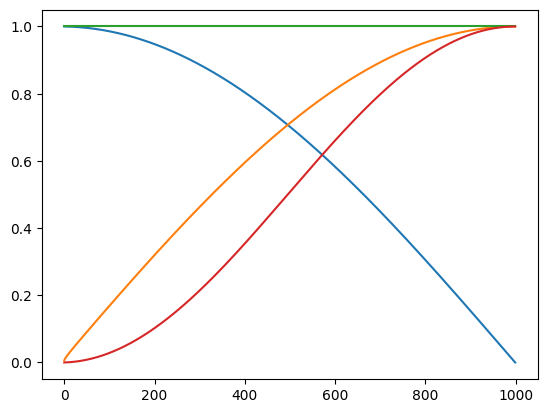

Continuous Cosine Noise Schedule


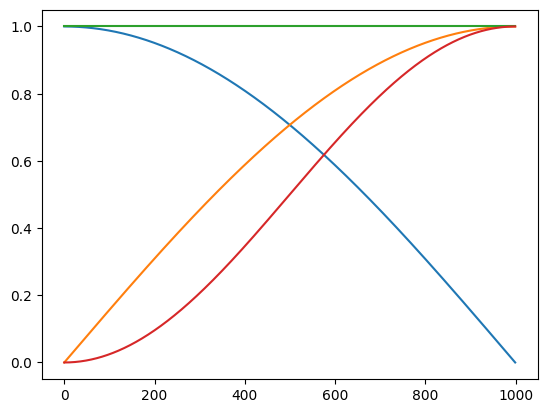

In [8]:
maxT = 1000
timesteps = jnp.linspace(0, maxT, 1000)
get_variance = lambda rates: rates[0] ** 2 + rates[1] ** 2
"""
Lets first plot the signal and noise rates for the discrete cosine noise schedule
"""
print("Discrete Cosine Noise Schedule")
schedule = CosineDiscreteNoiseSchedule(maxT)
plt.plot([schedule.get_rates(i, shape=()) for i in timesteps], label=["signal", "noise"])
plt.plot([get_variance(schedule.get_rates(i, shape=())) for i in timesteps], label="variance")
plt.plot([schedule.get_weights(i, shape=()) for i in timesteps], label="weights")
plt.show()

print("Continuous Cosine Noise Schedule")
schedule = CosineContinuousNoiseScheduler(maxT)
plt.plot([schedule.get_rates(i, shape=()) for i in timesteps], label=["signal", "noise"])
plt.plot([get_variance(schedule.get_rates(i, shape=())) for i in timesteps], label="variance")
plt.plot([schedule.get_weights(i) for i in timesteps], label="weights")
plt.show()


### Now lets test the noise scheduler on some simple images

We shall first sample some images from our dataset, then apply some noise to them using the noise scheduler, and then visualize the images at different time steps to see how the noise is added, and then how it is removed.

I0000 00:00:1721846163.782288    7478 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721846163.786692    7478 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721846163.786820    7478 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721846163.787414    7478 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

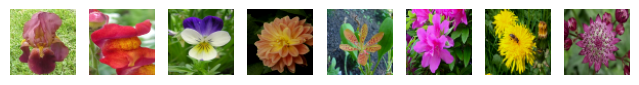

Rates: alpha=[[[[0.7071067]]]], sigma=[[[[0.7071068]]]]
Noisy Images


/tmp/ipykernel_7478/668185268.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  noise = jax.random.normal(jax.random.PRNGKey(4), shape=images.shape, dtype=jnp.float64)


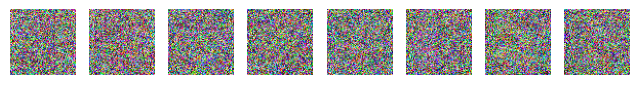

Reconstructed Images


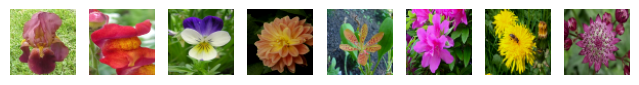

In [9]:
# Visualize adding some noise to some sample images and then removing it
data, _ = get_dataset("oxford_flowers102", batch_size=8, image_scale=64)
images = next(iter(data))
plotImages(images)
noise_level = 500
noise_level_max = 1000
schedule = CosineContinuousNoiseScheduler(noise_level_max)

alpha_t, sigma_t = schedule.get_rates(noise_level)
print(f"Rates: alpha={alpha_t}, sigma={sigma_t}") 
noise = jax.random.normal(jax.random.PRNGKey(4), shape=images.shape, dtype=jnp.float64)
noisy_images = schedule.add_noise(images, noise, noise_level)
print("Noisy Images")
plotImages(noisy_images)
print("Reconstructed Images")
reconstructed_images = schedule.remove_all_noise(noisy_images, noise, noise_level)
plotImages(reconstructed_images)

# Modeling

Neural network comes into play for learning to estimate the gradient $\nabla_{x_t} \log p_t(x_t)$ in the reverse diffusion process as described above:

$dx_t = [f(t, x_t) - g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t)] \, dt + g(t, x_t) \, d\bar{W}_t $

Score based models estimate the gradient $\nabla_{x_t} \log p_t(x_t)$ directly as

$ s_{\theta}(x_t) = \nabla_{x_t} \log p_t(x_t) $

where $s_{\theta}(x_t)$ is the score model, and $\theta$ are the parameters of the score model. But we can also model it in terms of a neural network that predicts the actual noise at time $t$ as well

$ \frac{\epsilon_{\theta}(x_t, t)}{\sigma_t} \approx - s_{\theta}(x_t) = \nabla_{x_t} \log p_t(x_t)  $

where $\epsilon_{\theta}(x_t, t)$ is the denoising model, and $\theta$ are the parameters of the denoising model.

*But why predict noise? Well we could also predict given a noisy sample, the original sample. That works too, but the first few original diffusion papers used the epsilon formulation and they argued that it was easier for a model to learn to predict the noise in an image rather than the original image itself. And anyway, once we have the noise, we can just subtract that from the noisy image to get the original image.*

In this notebook, we will be using this denoising model for solving the reverse diffusion process but there are other parameterizations as well that work really well. We will look into them in some other examples.

## Denoising Model

We will be using a simple UNet architecture for our denoising model. The UNet architecture is a popular architecture for image segmentation tasks, but it proves to be quite useful for denoising tasks as well. The architecture is quite simple and consists of an encoder and a decoder connected by skip connections. The encoder downsamples the input image and extracts features, while the decoder upsamples the features and reconstructs the image. The skip connections help in preserving spatial information and gradients.

We will also add some self attention blocks at each level of the UNet to help the model focus on finding clues in the image that are important for denoising.

The encoder and decoder blocks will be made of several resolution levels, and on each level will be made of several residual blocks, an attention block and a downsampling or upsampling block (for encoder and decoder respectively). There would also be a middle block of a single level of the same design but without downsampling or upsampling.

As our model $\epsilon_{\theta}(x_t, t)$ takes as input the time step $t$ as well, we will feed the model an additional input of the time step $t$ which would be added to each residual block after being embedded in a certain way and transformed and projected by few linear layers. The time step $t$ would be embedded in a way similar to how positional encodings are added in transformers. 

**We may use some separable convolutions in our model to reduce the number of parameters and thus the memory required. If these models do not compile on your machine, try switching all blocks to separable convs and than further reducing the resolution wise feature level sizes.**

## The basic building blocks

In [10]:
# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return nn.initializers.variance_scaling(scale=scale, mode="fan_avg", distribution="truncated_normal")

class NormalAttention(nn.Module):
    """
    Simple implementation of the normal attention.
    """
    query_dim: int
    heads: int = 4
    dim_head: int = 64
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGHEST
    use_bias: bool = True
    kernel_init: Callable = lambda : kernel_init(1.0)

    def setup(self):
        inner_dim = self.dim_head * self.heads
        dense = functools.partial(
            nn.DenseGeneral,
            features=[self.heads, self.dim_head], 
            axis=-1, 
            precision=self.precision, 
            use_bias=self.use_bias, 
            kernel_init=self.kernel_init(), 
            dtype=self.dtype
        )
        self.query = dense(name="to_q")
        self.key = dense(name="to_k")
        self.value = dense(name="to_v")

        self.proj_attn = nn.DenseGeneral(
            self.query_dim, 
            axis=(-2, -1), 
            precision=self.precision, 
            use_bias=self.use_bias, 
            dtype=self.dtype, 
            name="to_out_0",
            kernel_init=self.kernel_init()
            # kernel_init=jax.nn.initializers.xavier_uniform()
        )

    @nn.compact
    def __call__(self, x, context=None):
        # x has shape [B, H, W, C]
        context = x if context is None else context
        query = self.query(x)
        key = self.key(context)
        value = self.value(context)
        
        hidden_states = nn.dot_product_attention(
            query, key, value, dtype=self.dtype, broadcast_dropout=False, dropout_rng=None, precision=self.precision
        )
        proj = self.proj_attn(hidden_states)
        return proj
    
class AttentionBlock(nn.Module):
    heads: int = 4
    dim_head: int = 32
    use_linear_attention: bool = True
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGH
    use_projection: bool = False

    @nn.compact
    def __call__(self, x):
        inner_dim = self.heads * self.dim_head
        B, H, W, C = x.shape
        normed_x = nn.RMSNorm(epsilon=1e-5, dtype=self.dtype)(x)
        projected_x = NormalAttention(
            query_dim=C,
            heads=self.heads,
            dim_head=self.dim_head,
            name=f'Attention',
            precision=self.precision,
            use_bias=False,
        )(normed_x)
        out = x + projected_x
        return out
    
class TimeEmbedding(nn.Module):
    features:int
    nax_positions:int=10000

    def setup(self):
        half_dim = self.features // 2
        emb = jnp.log(self.nax_positions) / (half_dim - 1)
        emb = jnp.exp(-emb * jnp.arange(half_dim, dtype=jnp.float32))
        self.embeddings = emb

    def __call__(self, x):
        x = jax.lax.convert_element_type(x, jnp.float32)
        emb = x[:, None] * self.embeddings[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb
    
class TimeProjection(nn.Module):
    features:int
    activation:Callable=jax.nn.gelu

    @nn.compact
    def __call__(self, x):
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        return x

class SeparableConv(nn.Module):
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    use_bias:bool=False
    kernel_init:Callable=kernel_init(1.0)
    padding:str="SAME"

    @nn.compact
    def __call__(self, x):
        in_features = x.shape[-1]
        depthwise = nn.Conv(
            features=in_features, kernel_size=self.kernel_size,
            strides=self.strides, kernel_init=self.kernel_init,
            feature_group_count=in_features, use_bias=self.use_bias,
            padding=self.padding
        )(x)
        pointwise = nn.Conv(
            features=self.features, kernel_size=(1, 1),
            strides=(1, 1), kernel_init=self.kernel_init,
            use_bias=self.use_bias
        )(depthwise)
        return pointwise

class ConvLayer(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    kernel_init:Callable=kernel_init(1.0)

    def setup(self):
        if self.conv_type == "conv":
            self.conv = nn.Conv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )
        elif self.conv_type == "separable":
            self.conv = SeparableConv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )

    def __call__(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.swish

    @nn.compact
    def __call__(self, x, residual=None):
        out = x
        # out = PixelShuffle(scale=self.scale)(out)
        B, H, W, C = x.shape
        out = jax.image.resize(x, (B, H * self.scale, W * self.scale, C), method="nearest")
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(3, 3),
            strides=(1, 1),
        )(out)
        if residual is not None:
            out = jnp.concatenate([out, residual], axis=-1)
        return out

class Downsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.swish

    @nn.compact
    def __call__(self, x, residual=None):
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(3, 3),
            strides=(2, 2)
        )(x)
        if residual is not None:
            if residual.shape[1] > out.shape[1]:
                residual = nn.avg_pool(residual, window_shape=(2, 2), strides=(2, 2), padding="SAME")
            out = jnp.concatenate([out, residual], axis=-1)
        return out

class ResidualBlock(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    padding:str="SAME"
    activation:Callable=jax.nn.swish
    direction:str=None
    res:int=2
    norm_groups:int=8
    kernel_init:Callable=kernel_init(1.0)

    @nn.compact
    def __call__(self, x:jax.Array, temb:jax.Array, extra_features:jax.Array=None):
        residual = x
        out = nn.GroupNorm(self.norm_groups)(x)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv1"
        )(out)

        temb = nn.DenseGeneral(features=self.features, name="temb_projection")(temb)
        temb = jnp.expand_dims(jnp.expand_dims(temb, 1), 1)
        out = out + temb

        out = nn.GroupNorm(self.norm_groups)(out)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv2"
        )(out)

        if residual.shape != out.shape:
            residual = ConvLayer(
                self.conv_type,
                features=self.features,
                kernel_size=(1, 1),
                strides=1,
                kernel_init=self.kernel_init,
                name="residual_conv"
            )(residual)
        out = out + residual

        out = jnp.concatenate([out, extra_features], axis=-1) if extra_features is not None else out

        return out

## Main UNet Model

In [11]:

class Unet(nn.Module):
    emb_features:int=64*4,
    feature_depths:list=[64, 128, 256, 512],
    attention_configs:list=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}],
    num_res_blocks:int=2,
    num_middle_res_blocks:int=1,
    activation:Callable = jax.nn.swish
    norm_groups:int=8
    major_conv_type:str="conv"
    mid_conv_type:str="conv"

    @nn.compact
    def __call__(self, x, temb):
        temb = TimeEmbedding(features=self.emb_features)(temb)
        temb = TimeProjection(features=self.emb_features)(temb)
        feature_depths = self.feature_depths
        attention_configs = self.attention_configs

        conv_type = "conv"
        up_conv_type = down_conv_type = self.major_conv_type
        middle_conv_type = self.mid_conv_type

        x = ConvLayer(
            conv_type,
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(1.0)
        )(x)
        downs = [x]

        # Downscaling blocks
        for i, (dim_out, attention_config) in enumerate(zip(feature_depths, attention_configs)):
            dim_in = x.shape[-1]
            # dim_in = dim_out
            for j in range(self.num_res_blocks):
                x = ResidualBlock(
                    down_conv_type,
                    name=f"down_{i}_residual_{j}",
                    features=dim_in,
                    kernel_init=kernel_init(1.0),
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_in // attention_config['heads'],
                                       name=f"down_{i}_attention_{j}")(x)
                downs.append(x)
            if i != len(feature_depths) - 1:
                x = Downsample(
                    features=dim_out,
                    scale=2,
                    activation=self.activation,
                    name=f"down_{i}_downsample"
                )(x)

        # Middle Blocks
        middle_dim_out = self.feature_depths[-1]
        middle_attention = self.attention_configs[-1]
        for j in range(self.num_middle_res_blocks):
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res1_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)
            if middle_attention is not None and j == self.num_middle_res_blocks - 1:   # Apply attention only on the last block
                x = AttentionBlock(heads=attention_config['heads'], 
                                   dim_head=middle_dim_out // attention_config['heads'],
                                   use_linear_attention=False, name=f"middle_attention_{j}")(x)
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res2_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)

        # Upscaling Blocks
        for i, (dim_out, attention_config) in enumerate(zip(reversed(feature_depths), reversed(attention_configs))):
            for j in range(self.num_res_blocks):
                x = jnp.concatenate([x, downs.pop()], axis=-1)
                kernel_size = (3, 3)
                x = ResidualBlock(
                    up_conv_type,
                    name=f"up_{i}_residual_{j}",
                    features=dim_out,
                    kernel_init=kernel_init(1.0),
                    kernel_size=kernel_size,
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_out // attention_config['heads'],
                                       name=f"up_{i}_attention_{j}")(x)
            if i != len(feature_depths) - 1:
                x = Upsample(
                    features=feature_depths[-i],
                    scale=2,
                    activation=self.activation,
                    name=f"up_{i}_upsample"
                )(x)
    
        # x = nn.GroupNorm(8)(x)
        x = ConvLayer(
            conv_type,
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(0.0)
        )(x)
        
        x = jnp.concatenate([x, downs.pop()], axis=-1)

        x = ResidualBlock(
            conv_type,
            name="final_residual",
            features=self.feature_depths[0],
            kernel_init=kernel_init(1.0),
            kernel_size=(3,3),
            strides=(1, 1),
            activation=self.activation,
            norm_groups=self.norm_groups
        )(x, temb)

        x = nn.GroupNorm(self.norm_groups)(x)
        x = self.activation(x)

        noise_out = ConvLayer(
            conv_type,
            features=3,
            kernel_size=(3, 3),
            strides=(1, 1),
            # activation=jax.nn.mish
            kernel_init=kernel_init(0.0)
        )(x)
        return noise_out#, attentions

## Validate the model
**The output hasn't been rendered as it is too large to be rendered in the notebook.**

In [ ]:
model = Unet(emb_features=256,
             feature_depths=[64, 128, 256, 512],
             attention_configs=[None, {"heads": 8}, {"heads": 8}, {"heads": 8}],
             num_res_blocks=2,
             num_middle_res_blocks=1,
             major_conv_type="conv"
             )
inp = jnp.ones((1, 64, 64, 3))
temb = jnp.ones((1,))
print(model.tabulate(jax.random.key(0), inp, temb,
      console_kwargs={"width": 200, "force_jupyter": True, }))

# Training utils

We shall define some important utilities for training our model.
These are as follows:
- **Diffusion Prediction Transform**: Often the model's input and outputs need to be transformed to parameterize the model in the way we intend to. Although we are using the epsilon (denoising) formulation, using this general class to wrap the model can allow us to easily switch to other parameterizations as well.

- **TrainState**: This class will help us keep track of the training state of our model. It will keep track of the optimizer, the learning rate schedule, the model, the loss function, and the parameters of the model.

- **DiffusionTrainer**: This class will help us train our model. It will take in the train state and the training data and has the training loop defined in it. It would also periodically save the model parameters to disk

In [12]:
class DiffusionPredictionTransform():
    def pred_transform(self, x_t, preds, rates) -> jnp.ndarray:
        return preds
    
    def __call__(self, x_t, preds, current_step, noise_schedule:NoiseScheduler) -> Union[jnp.ndarray, jnp.ndarray]:
        rates = noise_schedule.get_rates(current_step)
        preds = self.pred_transform(x_t, preds, rates)
        x_0, epsilon = self.backward_diffusion(x_t, preds, rates)
        return x_0, epsilon
    
    def forward_diffusion(self, x_0, epsilon, rates: tuple[jnp.ndarray, jnp.ndarray]) -> Union[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        signal_rate, noise_rate = rates
        x_t = signal_rate * x_0 + noise_rate * epsilon
        expected_output = self.get_target(x_0, epsilon, (signal_rate, noise_rate))
        c_in = self.get_input_scale((signal_rate, noise_rate))
        return x_t, c_in, expected_output
    
    def backward_diffusion(self, x_t, preds, rates: tuple[jnp.ndarray, jnp.ndarray]) -> Union[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError
    
    def get_target(self, x_0, epsilon, rates) ->jnp.ndarray:
        return x_0
    
    def get_input_scale(self, rates: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
        return 1

class EpsilonPredictionTransform(DiffusionPredictionTransform):
    def backward_diffusion(self, x_t, preds, rates: tuple[jnp.ndarray, jnp.ndarray]) -> Union[jnp.ndarray, jnp.ndarray]:
        # preds is the predicted noise
        epsilon = preds
        signal_rates, noise_rates = rates
        x_0 = (x_t - epsilon * noise_rates) / signal_rates
        return x_0, epsilon
    
    def get_target(self, x_0, epsilon, rates) ->jnp.ndarray:
        return epsilon


In [13]:
import orbax.checkpoint

@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss') # type: ignore

# Define the TrainState with EMA parameters
class TrainState(train_state.TrainState):
    rngs: jax.random.PRNGKey
    ema_params: dict

    def get_random_key(self):
        rngs, subkey = jax.random.split(self.rngs)
        return self.replace(rngs=rngs), subkey

    def apply_ema(self, decay: float=0.999):
        new_ema_params = jax.tree_util.tree_map(
            lambda ema, param: decay * ema + (1 - decay) * param,
            self.ema_params,
            self.params,
        )
        return self.replace(ema_params=new_ema_params)

class DiffusionTrainer:
    state : TrainState
    best_state : TrainState
    best_loss : float
    model : nn.Module
    noise_schedule : NoiseScheduler
    model_output_transform:DiffusionPredictionTransform
    ema_decay:float = 0.999
    
    def __init__(self, 
                 model:nn.Module, 
                 optimizer: optax.GradientTransformation,
                 noise_schedule:NoiseScheduler,
                 rngs:jax.random.PRNGKey,
                 train_state:TrainState=None,
                 name:str="Diffusion",
                 load_from_checkpoint:bool=False,
                 param_transforms:Callable=None,
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform(),
                 loss_fn=optax.l2_loss,
                 image_size=64
                 ):
        self.model = model
        self.noise_schedule = noise_schedule
        self.name = name
        self.model_output_transform = model_output_transform
        self.loss_fn = loss_fn
        self.image_size = image_size

        checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=4, create=True)
        self.checkpointer = orbax.checkpoint.CheckpointManager(self.checkpoint_path(), checkpointer, options)

        if load_from_checkpoint:
            old_state, old_best_state = self.load()
        else:
            old_state, old_best_state = None, None

        if train_state == None:
            self.init_state(optimizer, rngs, existing_state=old_state, 
                            existing_best_state=old_best_state, 
                            model=model, param_transforms=param_transforms,
                            image_size=image_size
                            )
        else:
            self.state = train_state
            self.best_state = train_state
            self.best_loss = 1e9

    def init_state(self, 
                   optimizer: optax.GradientTransformation, 
                   rngs:jax.random.PRNGKey,
                   existing_state:dict=None,
                   existing_best_state:dict=None,
                   model:nn.Module=None,
                     param_transforms:Callable=None,
                     image_size=64
                   ):
        inp = jnp.ones((1, image_size, image_size, 3))
        temb = jnp.ones((1,))
        rngs, subkey = jax.random.split(rngs)

        if existing_state == None:
            params = model.init(subkey, inp, temb)
            existing_state = {"params":params, "ema_params":params}

        if param_transforms is not None:
            params = param_transforms(params)
        self.best_loss = 1e9
        self.state = TrainState.create(
            apply_fn=model.apply,
            params=existing_state['params'],
            ema_params=existing_state['ema_params'],
            tx=optimizer,
            rngs=rngs,
        )
        if existing_best_state is not None:
            self.best_state = self.state.replace(params=existing_best_state['params'], ema_params=existing_best_state['ema_params'])
        else:
            self.best_state = self.state

    def checkpoint_path(self):
        experiment_name = self.name
        path = os.path.join(os.path.abspath('./checkpoints'), experiment_name)
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def load(self):
        step = self.checkpointer.latest_step()
        print("Loading model from checkpoint", step)
        ckpt = self.checkpointer.restore(step)
        state = ckpt['state']
        best_state = ckpt['best_state']
        # Convert the state to a TrainState
        self.best_loss = ckpt['best_loss']
        print(f"Loaded model from checkpoint at step {step}", ckpt['best_loss'])
        return state, best_state

    def save(self, epoch=0):
        print(f"Saving model at epoch {epoch}")
        # filename = os.path.join(self.checkpoint_path(), f'model_{epoch}' if not best else 'best_model')
        ckpt = {
            'model': self.model,
            'state': self.state,
            'best_state': self.best_state,
            'best_loss': self.best_loss
        }
        save_args = orbax_utils.save_args_from_target(ckpt)
        self.checkpointer.save(epoch, ckpt, save_kwargs={'save_args': save_args})

    def summary(self):
        inp = jnp.ones((1, self.image_size, self.image_size, 3))
        temb = jnp.ones((1,))
        print(self.model.tabulate(jax.random.key(0), inp, temb, console_kwargs={"width": 200, "force_jupyter":True, }))

    def _define_train_step(self):
        noise_schedule = self.noise_schedule
        model = self.model
        model_output_transform = self.model_output_transform
        loss_fn = self.loss_fn
        @jax.jit
        def train_step(state:TrainState, batch):
            """Train for a single step."""
            images = batch
            noise_level, state = noise_schedule.generate_timesteps(images.shape[0], state)
            state, rngs = state.get_random_key()
            noise:jax.Array = jax.random.normal(rngs, shape=images.shape)
            rates = noise_schedule.get_rates(noise_level)
            noisy_images, c_in, expected_output = model_output_transform.forward_diffusion(images, noise, rates)
            def model_loss(params):
                preds = model.apply(params, *noise_schedule.transform_inputs(noisy_images*c_in, noise_level))
                preds = model_output_transform.pred_transform(noisy_images, preds, rates)
                nloss = loss_fn(preds, expected_output)
                nloss *= noise_schedule.get_weights(noise_level)
                nloss = jnp.mean(nloss)
                loss = nloss
                return loss
            loss, grads = jax.value_and_grad(model_loss)(state.params)
            state = state.apply_gradients(grads=grads) 
            state = state.apply_ema(self.ema_decay)
            return state, loss
        return train_step
    
    def _define_compute_metrics(self):
        @jax.jit
        def compute_metrics(state:TrainState, expected, pred):
            loss = jnp.mean(jnp.square(pred - expected))
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        return compute_metrics

    def fit(self, data, steps_per_epoch, epochs):
        data = iter(data)
        train_step = self._define_train_step()
        compute_metrics = self._define_compute_metrics()
        state = self.state
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            start_time = time.time()
            epoch_loss = 0
            with tqdm.tqdm(total=steps_per_epoch, desc=f'\t\tEpoch {epoch+1}', ncols=100, unit='step') as pbar:
                for i in range(steps_per_epoch):
                    batch = next(data)
                    state, loss = train_step(state, batch)
                    epoch_loss += loss
                    if i % 100 == 0:
                        pbar.set_postfix(loss=f'{loss:.4f}')
                        pbar.update(100)
            end_time = time.time()
            self.state = state
            total_time = end_time - start_time
            avg_time_per_step = total_time / steps_per_epoch
            avg_loss = epoch_loss / steps_per_epoch
            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                self.best_state = state
                self.save(epoch)
            print(f"\n\tEpoch {epoch+1} completed. Avg Loss: {avg_loss}, Time: {total_time:.2f}s, Best Loss: {self.best_loss}")
        self.save(epochs)
        return self.state


# Training

We shall first define the schedules we would wanna use, and then the model, some params, the optimizer and the trainer,
and then start training the model.

In [14]:
cosine_schedule = CosineDiscreteNoiseSchedule(1000)

In [17]:
experiment_name = "{name}_{date}".format(
    name="Diffusion_SDE_VE", date=datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
)
print("Experiment_Name:", experiment_name)
unet = Unet(emb_features=256,
             feature_depths=[64, 128, 256, 512],
             attention_configs=[None, {"heads": 8}, {"heads": 8}, {"heads": 8}],
             num_res_blocks=2,
             num_middle_res_blocks=1,
             major_conv_type="conv",
             mid_conv_type="conv"
)

BATCH_SIZE=16
IMAGE_SIZE=64

data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
batches = datalen // BATCH_SIZE

# Suggested configurations
total_epochs = 1000
steps_per_epoch = batches
learning_rate = 2e-4

solver = optax.adam(learning_rate)

trainer = DiffusionTrainer(unet, optimizer=solver, 
                           noise_schedule=cosine_schedule,
                           rngs=jax.random.PRNGKey(4), 
                           name=experiment_name,
                           model_output_transform=EpsilonPredictionTransform(),
                           )

Experiment_Name: Diffusion_SDE_VE_2024-07-25_00:07:09


In [ ]:
trainer.summary()

In [ ]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=total_epochs)

In [14]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=total_epochs)

		Epoch 479: 600step [00:21, 28.32step/s, loss=0.0160]                                              



	Epoch 479 completed. Avg Loss: 0.029866138473153114, Time: 21.19s, Best Loss: 0.028689149767160416

Epoch 480/500


		Epoch 480: 600step [00:21, 28.39step/s, loss=0.0227]                                              



	Epoch 480 completed. Avg Loss: 0.029083119705319405, Time: 21.14s, Best Loss: 0.028689149767160416

Epoch 481/500


		Epoch 481: 600step [00:20, 28.62step/s, loss=0.0324]                                              



	Epoch 481 completed. Avg Loss: 0.029530460014939308, Time: 20.96s, Best Loss: 0.028689149767160416

Epoch 482/500


		Epoch 482: 600step [00:20, 28.76step/s, loss=0.0406]                                              



	Epoch 482 completed. Avg Loss: 0.030211661010980606, Time: 20.86s, Best Loss: 0.028689149767160416

Epoch 483/500


		Epoch 483: 600step [00:20, 28.76step/s, loss=0.0125]                                              



	Epoch 483 completed. Avg Loss: 0.029092974960803986, Time: 20.86s, Best Loss: 0.028689149767160416

Epoch 484/500


		Epoch 484: 600step [00:21, 28.55step/s, loss=0.0148]                                              



	Epoch 484 completed. Avg Loss: 0.030012203380465508, Time: 21.02s, Best Loss: 0.028689149767160416

Epoch 485/500


		Epoch 485: 600step [00:21, 27.97step/s, loss=0.0362]                                              



	Epoch 485 completed. Avg Loss: 0.0298771895468235, Time: 21.45s, Best Loss: 0.028689149767160416

Epoch 486/500


		Epoch 486: 600step [00:20, 28.68step/s, loss=0.0265]                                              



	Epoch 486 completed. Avg Loss: 0.028736811131238937, Time: 20.92s, Best Loss: 0.028689149767160416

Epoch 487/500


		Epoch 487: 600step [00:21, 28.39step/s, loss=0.0130]                                              



	Epoch 487 completed. Avg Loss: 0.030445363372564316, Time: 21.13s, Best Loss: 0.028689149767160416

Epoch 488/500


		Epoch 488: 600step [00:20, 28.78step/s, loss=0.0173]                                              



	Epoch 488 completed. Avg Loss: 0.030167413875460625, Time: 20.85s, Best Loss: 0.028689149767160416

Epoch 489/500


		Epoch 489: 600step [00:19, 30.78step/s, loss=0.0235]                                              



	Epoch 489 completed. Avg Loss: 0.030147340148687363, Time: 19.49s, Best Loss: 0.028689149767160416

Epoch 490/500


		Epoch 490: 600step [00:18, 32.22step/s, loss=0.0244]                                              



	Epoch 490 completed. Avg Loss: 0.030014051124453545, Time: 18.62s, Best Loss: 0.028689149767160416

Epoch 491/500


		Epoch 491: 600step [00:18, 32.38step/s, loss=0.0258]                                              



	Epoch 491 completed. Avg Loss: 0.029319005087018013, Time: 18.53s, Best Loss: 0.028689149767160416

Epoch 492/500


		Epoch 492: 600step [00:18, 32.31step/s, loss=0.0143]                                              



	Epoch 492 completed. Avg Loss: 0.029114603996276855, Time: 18.57s, Best Loss: 0.028689149767160416

Epoch 493/500


		Epoch 493: 600step [00:18, 32.31step/s, loss=0.0327]                                              



	Epoch 493 completed. Avg Loss: 0.03023139014840126, Time: 18.57s, Best Loss: 0.028689149767160416

Epoch 494/500


		Epoch 494: 600step [00:18, 32.12step/s, loss=0.0406]                                              



	Epoch 494 completed. Avg Loss: 0.02999108098447323, Time: 18.68s, Best Loss: 0.028689149767160416

Epoch 495/500


		Epoch 495: 600step [00:18, 32.08step/s, loss=0.0437]                                              



	Epoch 495 completed. Avg Loss: 0.02919759228825569, Time: 18.70s, Best Loss: 0.028689149767160416

Epoch 496/500


		Epoch 496: 600step [00:18, 32.06step/s, loss=0.0270]                                              



	Epoch 496 completed. Avg Loss: 0.030035417526960373, Time: 18.71s, Best Loss: 0.028689149767160416

Epoch 497/500


		Epoch 497: 600step [00:19, 31.56step/s, loss=0.0269]                                              



	Epoch 497 completed. Avg Loss: 0.029354268684983253, Time: 19.01s, Best Loss: 0.028689149767160416

Epoch 498/500


		Epoch 498: 600step [00:19, 30.60step/s, loss=0.0279]                                              



	Epoch 498 completed. Avg Loss: 0.030987652018666267, Time: 19.61s, Best Loss: 0.028689149767160416

Epoch 499/500


		Epoch 499: 600step [00:18, 31.92step/s, loss=0.0126]                                              



	Epoch 499 completed. Avg Loss: 0.029249167069792747, Time: 18.80s, Best Loss: 0.028689149767160416

Epoch 500/500


		Epoch 500: 600step [00:19, 30.48step/s, loss=0.0236]                                              



	Epoch 500 completed. Avg Loss: 0.029589233919978142, Time: 19.69s, Best Loss: 0.028689149767160416
Saving model at epoch 500


# Generate Samples

## The Intuition of reverse diffusion process

As described before, the process of diffusion is basically traveling from a point in the input space of low entropy to a point of high entropy (forward time diffusion) or vice versa (the reverse diffusion). 

Lets try to understand the **reverse diffusion process** as forward diffusion is easy to understand: Things go from hot to cold, from ordered to unordered, things diffuse out from order to chaos aka noise. We have talked about it in the introduction to this notebook.

Every image or noise aka sample is basically a point in a high dimensional input space (to be precise, in a 64 x 64 x 3 dimensions space!). In the start, to generate a new image, you randomly start from some random point in the input space (as the initial sample image you start with for generating your images are random gaussian noise). Now, as the point you started with was random, its most probable that its not a good image resembling you dataset. Afterall, high dimensional spaces are REALLY FREAKING HUGE! 

So, we need to find our way to some useful point in this input space which actually resembles some meaninful image (which there would be for sure as by definition, in an infinite space, everything exists!). But randomly trying to stumble your way to it would be really hard and time taking (like really really really time taking, black holes would die before you find a good image). So, we need to find a way to guide us. And thats what those pesky differential equations are for! They describe a path way back from noise to signal aka data. 

The idea is simple. We have a neural network model that, provided a noisy image, can try to predict the denoised image. This means that given the current point in the input space, the model can learn to predict some point in it's vicinity that is more likely to be a good viable image. But ofcourse neural networks are imperfect. What GANs and VAEs etc failed to realize was this very fact that you won't get a perfect image in one go. We should treat it as a rough guess. What we then do is, take a very small step in the direction of the predicted image, and then predict again. This time the idea is that the model's prediction would be closer to some meaningful image. We keep doing this until we reach a point where the model's prediction is very close to the actual image. This is the reverse diffusion process.

Now, this process of taking a small step in the direction of the predicted image, which honestly is indeed gradient decent but in input space, can be thought in the way that you actually went to the predicted point, and then came back again near to our original point but a bit closer to the predicted point, i.e, you traveled all the way to the prediction and then came mostly back but not quite completely. This is the same as saying you took a small step in that direction but this idea is actually exactly how the simplest technique for generating images aka sampling works: The DDIM (Denoising Diffusion Implicit Model). Samplers of this type are broadly defined as ordinary differential equation (ODE) solvers as our reverse diffusion process is defined as an ODE (reminder, a differential equation is just a fancy way of talking about how things change with respect to some other thing like time).

Now that we think of it this way, there is also another thing that we can do, When we get to the predicted point, we had actually a choice that we could either come back precisely in the direction of the original point, or we could come back in the rough direction (i.e, mostly the direction but with some random uncertainity). What this does is, it allows the model to try find that perfect data point from multiple other directions rather than the same direction, allowing for even better error minimization and thus better quality (atleast mostly, although its painfully slow, infact the slowest method for sampling). This is the idea behind the DDPM (Denoising Diffusion Probabilistic Model). These samplers are defined as stochastic differential equation (SDE) solvers as our reverse diffusion process is defined as an SDE.

## Sampling from the model

Sampling or generating images is basically the reverse diffusion process. It can either be thought of as a markov chain of conditional distributions $p(x_{t−1}|x_t)$ if we are using the DDPM's discrete time step formulation, or as numerically integrating a stochastic differential equation (SDE) if we are talking about general continuous time step formulations. But even in the case of the SDE, We actually would be integrating the SDE over discrete time steps ofcourse, because we can't really integrate over infinite time steps in a computer, we simply do not have infinite time.

Although we would like to follow the formulations of DDPM paper even further, for the sake of simplicity and ease of understanding, we shall use the differential equation formulations in this notebook for generating samples. But keep in mind that both are equivalent and the only difference is in the way its written. The images generated are exactly the same.

As discussed previously, the reverse diffusion process can be thought of as a stochastic differential equation (SDE):

$dx_t = [f(t, x_t) - g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t)] \, dt + g(t, x_t) \, d\bar{W}_t $

where:
- $ dx_t $ is the infinitesimal change in the data sample $ x_t $ at time $ t $,
- $ f(t, x_t) $ is the drift term from the forward process,
- $ g(t, x_t) $ is the diffusion term from the forward process,
- $ \nabla_{x_t} \log p_t(x_t) $ is the gradient of the log-density of the data at time $ t $,
- $ d\bar{W}_t $ is the infinitesimal increment of a reverse-time Wiener process (or standard Brownian motion).

or a corresponding probability flow ordinary differential equation (ODE):

$ \frac{dx_t}{dt} = f(t, x_t) - \frac{1}{2} g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t) $

where:
- $\frac{dx_t}{dt}$ is the time derivative of the data sample $x_t$,
- $f(t, x_t)$ is the drift term from the forward process,
- $g(t, x_t)$ is the diffusion term from the forward process,
- $\nabla_{x_t} \log p_t(x_t)$ is the gradient of the log-density of the data at time $t$.

We model the term $\nabla_{x_t} \log p_t(x_t)$ as a neural network. Our current formulation of 'denoising' or noise predicting (epsilon predicting) model is

$ \frac{\epsilon_{\theta}(x_t, t)}{\sigma_t} \approx - = \nabla_{x_t} \log p_t(x_t) $

Thus we have a detailed mathematical description of our reverse diffusion process. But having a differential equation is just having a description of the process, to actually get something out of it like what happens at the end of the process, we need to solve the differential equation. And by solving, we mean to integrate it over a range of time steps $t$. Doing this shall get us to a final generated sample given an initial starting sample.

These integrators are defined in FlaxDiff as DiffusionSampler classes.

We shall now first define a general abstract DiffusionSampler class, which we can later extend to implement various samplers.

In [20]:
def clip_images(images, clip_min=-1, clip_max=1):
    return jnp.clip(images, clip_min, clip_max)

class DiffusionSampler():
    model:nn.Module
    noise_schedule:NoiseScheduler
    params:dict
    model_output_transform:DiffusionPredictionTransform

    def __init__(self, model:nn.Module, params:dict,  
                 noise_schedule:NoiseScheduler, 
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform()):
        self.model = model
        self.noise_schedule = noise_schedule
        self.params = params
        self.model_output_transform = model_output_transform

        @jax.jit
        def sample_model(x_t, t):
            rates = self.noise_schedule.get_rates(t)
            c_in = self.model_output_transform.get_input_scale(rates)
            model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t * c_in, t))
            x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
            # print(f"model output {jnp.mean(model_output)}, x_0 {jnp.mean(x_0)}, eps {jnp.mean(eps)}")
            return x_0, eps, model_output
        
        self.sample_model = sample_model

    # Used to sample from the diffusion model
    def sample_step(self, current_samples:jnp.ndarray, current_step, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        # First clip the noisy images
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        pred_images, pred_noise, _ = self.sample_model(current_samples, current_step)
        # plotImages(pred_images)
        pred_images = clip_images(pred_images)
        new_samples, state =  self.take_next_step(current_samples=current_samples, reconstructed_samples=pred_images, 
                             pred_noise=pred_noise, current_step=current_step, next_step=next_step, state=state)
        return new_samples, state

    def take_next_step(self, current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # estimate the p(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        return NotImplementedError
    
    def scale_steps(self, steps):
        scale_factor = self.noise_schedule.max_timesteps / 1000
        return steps * scale_factor

    def get_steps(self, start_step, end_step, diffusion_steps):
        step_range = start_step - end_step
        if diffusion_steps is None or diffusion_steps == 0:
            diffusion_steps = start_step - end_step
        diffusion_steps = min(diffusion_steps, step_range)
        steps = jnp.linspace(end_step, start_step, diffusion_steps, dtype=jnp.int16)[::-1]
        return steps
    
    def get_initial_samples(self, num_images, rngs:jax.random.PRNGKey, start_step, image_size=64):
        start_step = self.scale_steps(start_step)
        alpha_n, sigma_n = self.noise_schedule.get_rates(start_step)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        return jax.random.normal(rngs, (num_images, image_size, image_size, 3)) * variance

    def generate_images(self,
                        num_images=16, 
                        diffusion_steps=1000, 
                        start_step:int = None,
                        end_step:int = 0,
                        steps_override=None,
                        priors=None, 
                        rngstate:RandomMarkovState=RandomMarkovState(jax.random.PRNGKey(42))) -> jnp.ndarray:
        if priors is None:
            rngstate, newrngs = rngstate.get_random_key()
            samples = self.get_initial_samples(num_images, newrngs, start_step)
        else:
            print("Using priors")
            samples = priors

        @jax.jit
        def sample_step(state:RandomMarkovState, samples, current_step, next_step):
            samples, state = self.sample_step(current_samples=samples,
                                              current_step=current_step, 
                                              state=state, next_step=next_step)
            return samples, state

        if start_step is None:
            start_step = self.noise_schedule.max_timesteps

        if steps_override is not None:
            steps = steps_override
        else:
            steps = self.get_steps(start_step, end_step, diffusion_steps)

        # print("Sampling steps", steps)
        for i in tqdm.tqdm(range(0, len(steps))):
            current_step = self.scale_steps(steps[i])
            next_step = self.scale_steps(steps[i+1] if i+1 < len(steps) else 0)
            if i != len(steps) - 1:
                # print("normal step")
                samples, rngstate = sample_step(rngstate, samples, current_step, next_step)
            else:
                # print("last step")
                step_ones = jnp.ones((num_images, ), dtype=jnp.int32)
                samples, _, _ = self.sample_model(samples, current_step * step_ones)
        samples = clip_images(samples)
        return samples


## DDIM Sampler

The Denoising Diffusion Implicit Model (DDIM) Sampler implements the idea we discussed above, that we shall, starting from the current noisy point in the input space, get to the predicted point by the model, and then come almost all the way back in the precise direction of our original image. This 'almost all the way' is defined by the magnitude of how noise rates change in our noise schedule over time. This is the simplest and the fastest way to sample from the model and can generate good resolution images within fraction of the time steps than what going through each time step would take. eg, if the total time steps we were talking about were 1000, this method would take only 100 time steps to generate a good image. But the quality won't be as good as DDPM or SDE solvers ofcourse.

$ x_{t-1} = \alpha_{t-1} x_{0}(t) + \sigma_{t-1} \epsilon_{0} $

where:
- $x_{t-1}$ is the data sample at time $t-1$ aka the next predicted sample,
- $x_{0}(t)$ is the initial data sample as predicted by our model from the current sample $x_t$,
- $\epsilon_{0}$ is the original gaussian noise sample from which we started,

In [21]:
class DDIMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        return reconstructed_samples * next_signal_rate + pred_noise * next_noise_rate, state

100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


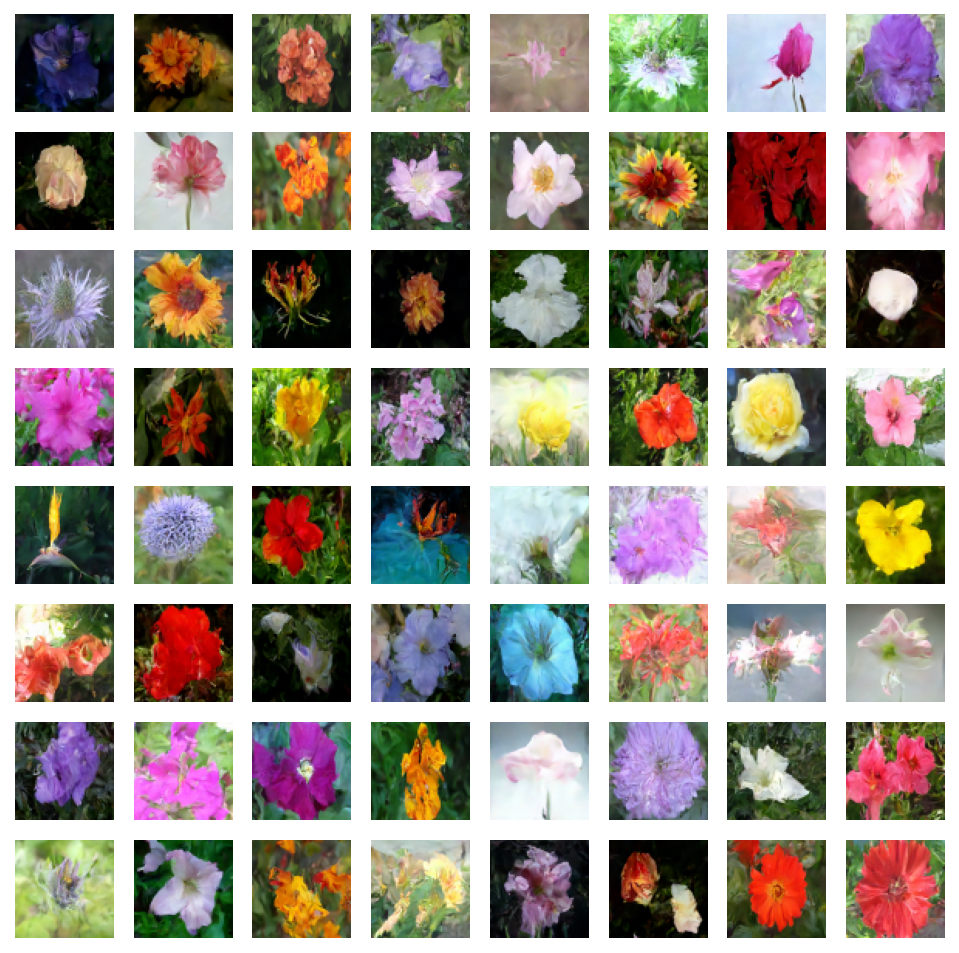

In [26]:
sampler = DDIMSampler(trainer.model, trainer.state.ema_params, cosine_schedule, model_output_transform=EpsilonPredictionTransform())
samples = sampler.generate_images(num_images=64, diffusion_steps=100, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=150)

## Euler Method

Now that we have looked at the simplest possible sampler according to our intuition, lets now harness the power of maths and look at solving aka integrating the ODEs and SDEs we talked about. 

The Euler Method is the simplest ODE/SDE solver to implement and thus understand. To explain what the Euler method (and thus a solver) is, we shall first look at how to integrate a very simple and familar differential equation, the differential equation of an object in constant acceleration.

When an object is in constant acceleration, it means that it's speed is increasing at a constant rate. We were taught in our high school physics classes that the speed of an object at any time $t$ is given by the equation:

$v(t) = v_0 + a t$

where:
- $v(t)$ is the speed of the object at time $t$,
- $v_0$ is the initial speed of the object,
- $a$ is the acceleration of the object,
- $t$ is the time.

In terms of position, the position of the object at any time $t$ is given by the equation:

$x(t) = x_0 + v_0 t + \dfrac{1}{2} a t^2$               eqn 1

where:
- $x(t)$ is the position of the object at time $t$,
- $x_0$ is the initial position of the object.

We can see that an object under constant acceleration would have a quadratic position-time graph, which would look like a parabola.

Well, the above equations are actually integrals. What acceleration really is is rate of change of speed which in itself is rate of change of position. So, we can also say that for an object under constant acceleration, it's rate of change of speed is constant:

$\dfrac{dv(t)}{dt} = a$

Which basically means that it's rate of change of position (i.e speed) is increasing at a constant rate:

$\dfrac{dx(t)}{dt} = v(t)$

Thus we can have a differential equation for the position of the object as:

$\dfrac{dx(t)}{dt} = v_0 + a t$

This differential equation captures the essence of an object under constant acceleration and describes how it will behave over time. This is what differential equations are for, to describe how a system will evolve over time or some other variable.
This is a very simple differential equation and I bet you can solve i.e integrate it using high school calculus to get the equation 1. But differential equations are not always as simple to integrate as this one. For more complex systems, we need to use numerical methods to solve them. 

And thats where the Euler method comes in. Taking our acceleting body example, if we want to know the actual position of the object w.r.t time $t$, our differential equation tells us that its some value changing over time in some very small time steps (infinitesimal in reality but thats not possible in reality so lets stick with 'very small'). Well, the integral is just a sum of all these very small changes over time i.e, the area under the curve. So why not just do exactly that? Thats what the euler method does. 

To illustrate, lets just define our differential equation for the position of the object under constant acceleration as:

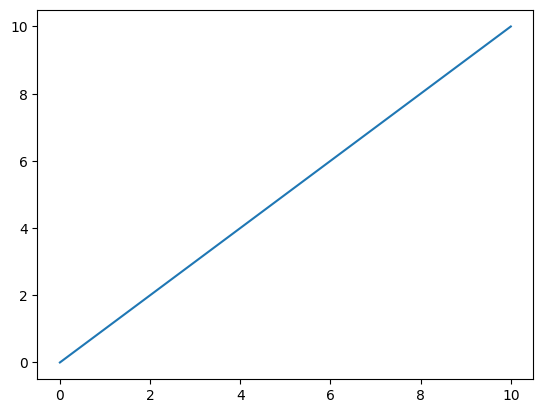

In [27]:
# Simple differential equation for increasing speed with constant rate (constant acceleration)
# dX = X0 + t * dt
def dX(dt: float, X0: float, t: float, a: float = 1, **params) -> float:
    return X0 + t * a * dt 

# We can plot the function to see how dX changes with time
t = jnp.linspace(0, 10, 1000)
X0 = 0
dt = 1
a = 1
plt.plot(t, dX(dt, X0, t, a))
# We should get a straight line with slope a to signify that the speed is increasing linearly

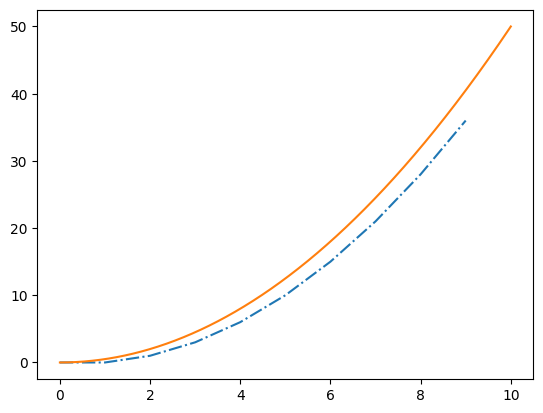

In [28]:
# Now let us integrate this linear function to get the position
def eulerIntegrate(dX: Callable, X0: float, dt: float, max_t:float = 1000, **params):
    steps = int(max_t / dt)
    X = []
    t = []
    t0 = 0
    Xval = X0
    tVal = t0
    for i in jnp.linspace(0, max_t, steps):
        t.append(tVal)
        X.append(Xval)
        Xval += dX(X0=X0, dt=dt, X=Xval, t=tVal, **params) * dt
        tVal += dt
    return jnp.array(t), jnp.array(X)

def plotDiff(dX: Callable, X0: float, dt: float, max_t:float = 1000, **params):
    # Integrate the system
    t, X = eulerIntegrate(dX, X0, dt, max_t, **params)
    plt.plot(t, X, linestyle='dashdot')
    
    
plotDiff(dX=dX, X0=X0, dt=dt, a=a, max_t=10)
# We should get a parabolic curve to signify that the position is increasing quadratically

# Now let us plot the actual X(t) = X0 + V0 * t + 0.5 * a * t^2
def X(t: float, X0: float, V0: float, a: float) -> float:
    return X0 + V0 * t + 0.5 * a * t ** 2

# We can plot the function to see how X changes with time
plt.plot(t, X(t, X0, 0, a), linestyle='solid')

From the above demonstration, we can see that the euler method does give us an approximation of the actual solution to the differential equation. But the approximation is not perfect because the timesteps are not infinitesimally small. There are other more advanced numerical solvers that can integrate even better than this with the same imperfect timesteps as well such as Heun's method, Runge-Kutta methods, etc. But the euler method is the simplest and easiest to understand and implement.

### The Euler Sampler

The Euler Sampler is basically our SDE/ODE solver that integrates the reverse diffusion process over given time steps and is implements our DiffusionSampler class.
In this notebook, we shall define the EulerSampler to be a solver of the corresponding probability flow ODE of our SDE diffusion process. This basically means that there would be no new randomness introduced in the integration process and is as simple as it can get i.e, just like the euler method for the constant acceleration example. EulerSampler is thus our implementation of the Euler method for solving the reverse diffusion probability flow ODE. If we were to use the Euler method for solving the reverse diffusion SDE, we would call it the Euler-A sampler (A for Ancestral). The idea is the same, but there is some stochasticity aka noise in that process.

This sampler is actually also equivalent and identical to the DDIM technique and yields the same results. As an exercise, you can try to find the algebraic equivalence between the two.

In [29]:

class EulerSampler(DiffusionSampler):
    # Basically a DDIM Sampler but parameterized as an ODE
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma         # Actually its not dt at all, but rather dsigma
        
        # We get the following X0 coefficient from simple algebra over trying to find the differential equation for 
        # our forward processes formulated as X_t = alpha * X_0 + sigma * epsilon. You can do the algebra bit yourself as 
        # an exercise.
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (dt)
        
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        
        next_samples = current_samples + dx * dt        # The Euler Integration Step
        return next_samples, state
    

100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


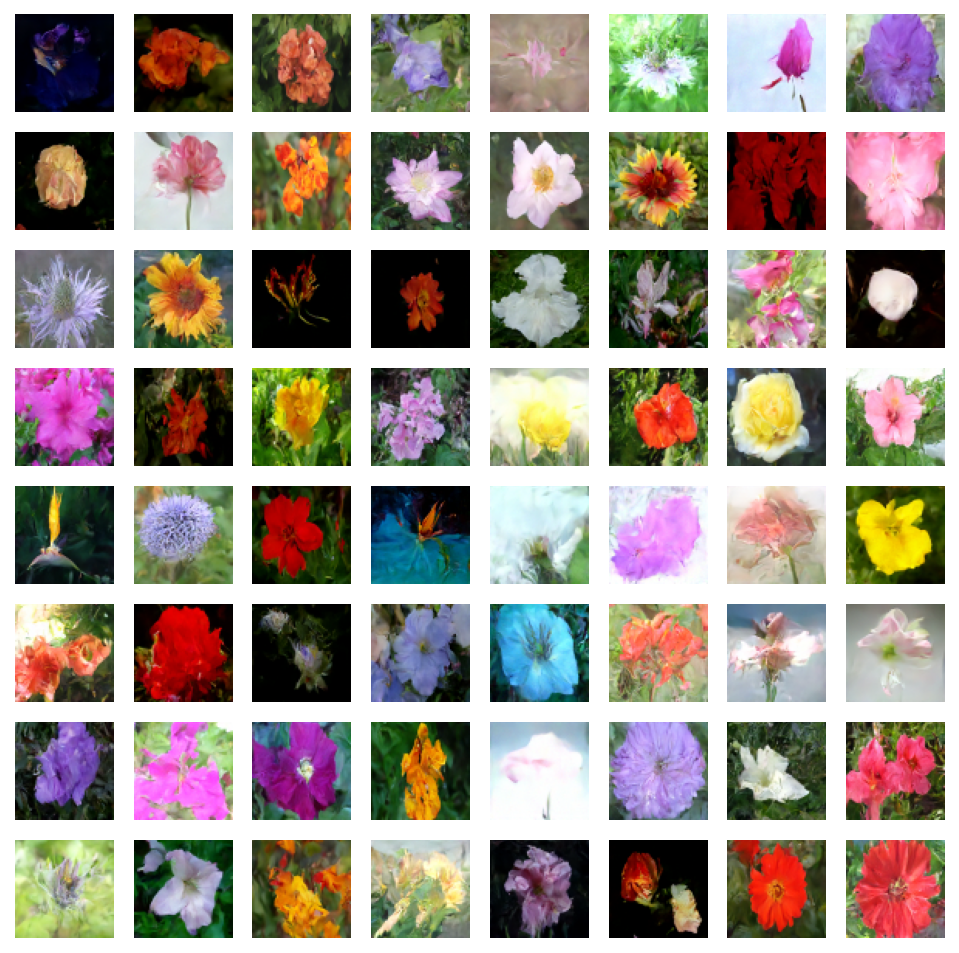

In [30]:
sampler = EulerSampler(trainer.model, trainer.state.ema_params, cosine_schedule, model_output_transform=EpsilonPredictionTransform())
samples = sampler.generate_images(num_images=64, diffusion_steps=100, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=150)

**Please ignore the over exposure of the images for now, should not have occured, will fix soon.**

## The (Denoising Diffusion Probabilistic Model) DDPM Sampler

Above, just for sake of simplicity and to have the essence of the concept, we defined the DDIMSampler EulerSampler, but now that we have seen that our model works and how to sample from it, lets talk about the DDPM sampler as presented in the original DDPM paper. In the introduction to this notebook, we discussed that the reverse diffusion process is defined as a markov chain of conditional distributions $p(x_{t−1}|x_t)$ as follows:

$p_\theta(x_{t−1}|x_t) := \mathcal{N}(x_{t−1};\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$

where:
- $x_{t−1}$ is the data sample at time $t-1$,
- $x_t$ is the data sample at time $t$,
- $\mu_\theta(x_t, t)$ is the mean of the reverse distribution,
- $\Sigma_\theta(x_t, t)$ is the covariance of the reverse distribution.

Therefore, If we want to generate images following the DDPM technique (which is actually equivalent to solving the reverse diffusion SDE via Euler method, also called Euler-Ancestral sampler), we need to follow the above markov chain of conditional distributions. This is what our DDPM Sampler does.

### The Implementation

The term $\mu_\theta(x_t, t)$ i.e, the mean of the conditional distribution is the term parameterized by our model (with weights $\theta$), But its not just the model. To be precise, In the DDPM paper, this term is defined as:

$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)$

where:
- $x_t$ is the data sample at time $t$,
- $\alpha_t$ is defined as $\alpha_t = 1 - \beta_t$, **This is not the same as our signal rate $\alpha_t$ that we use, so be careful with the notation**,
- $\bar{\alpha}_t$ is defined as $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s
- $\beta_t$ is the $\beta(t)$ parameter of the noise schedule at time $t$ which we discussed in our ![Noise Schedulers](#Cosine-Noise-Scheduler-in-terms-of-$\beta(t)$) sections,
- $\epsilon_\theta(x_t, t)$ is the denoising model (i.e, model trained in epsilon prediction model), and $\theta$ are the parameters of the denoising model.

Don't forget, the way forward diffusion is defined in DDPM is:

$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$

Thus, the signal term in DDPM is $\sqrt{\bar{\alpha}_t}$ and the noise term is $\sqrt{1 - \bar{\alpha}_t}$. Remember this to understand our DDPM sampler.

The term $\Sigma_\theta(x_t, t)$ i.e, the covariance of the conditional distribution is defined as:

$\Sigma_\theta(x_t, t) = \sigma_t^2 I 

and

$tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$

where:
- $\sigma_t$ is the standard deviation of the new noise added at time $t$,
- $\beta_t$ is the $\beta(t)$ parameter of the noise schedule at time $t$ which we discussed 

We shall implement the DDPM Sampler in two variations: The exact formulation we discussed as DDPMSampler, and an algebraically equivalent but more simplified version as SimpleDDPMSampler. You can try to find the algebraic equivalence between the two as an exercise.

**As the DDPM paper uses sigma as the standard deviation of the new noise but we use it as the noise rate aka standard devitation of all the noise in general, we shall use the term $\gamma$ instead:**

$\Sigma_\theta(x_t, t) = \gamma_t^2 I$

**As we do not have access to the $\beta(t)$ parameter of the noise schedule, we can calculate it back from the current and next signal rates (or noise rates for that matter) as follows:**

$\beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}$

**Fun Fact, DDIM is just a special case of DDPM where the new noise added is actually the original noise sample from which we started. This is to be expected as DDIM is the probability flow ODE of DDPM's SDE. You can try to find the algebraic equivalence between the two as an exercise.**

In [32]:
class DDPMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        new_noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)
        current_signal_rate, current_noise_rate = self.noise_schedule.get_rates(current_step)
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        
        noise_ratio_squared = (next_noise_rate ** 2) / (current_noise_rate ** 2)
        signal_ratio_squared = (current_signal_rate ** 2) / (next_signal_rate ** 2)
        
        betas = (1 - signal_ratio_squared)
        gamma = jnp.sqrt(noise_ratio_squared * betas)
        
        something_small = 1e-6 # To prevent division by zero
        
        next_samples = (1 / (jnp.sqrt(1 - betas) + something_small)) * (current_samples - betas * (pred_noise / current_noise_rate)) + new_noise * gamma
        return next_samples, state

100%|██████████| 998/998 [00:57<00:00, 17.46it/s]


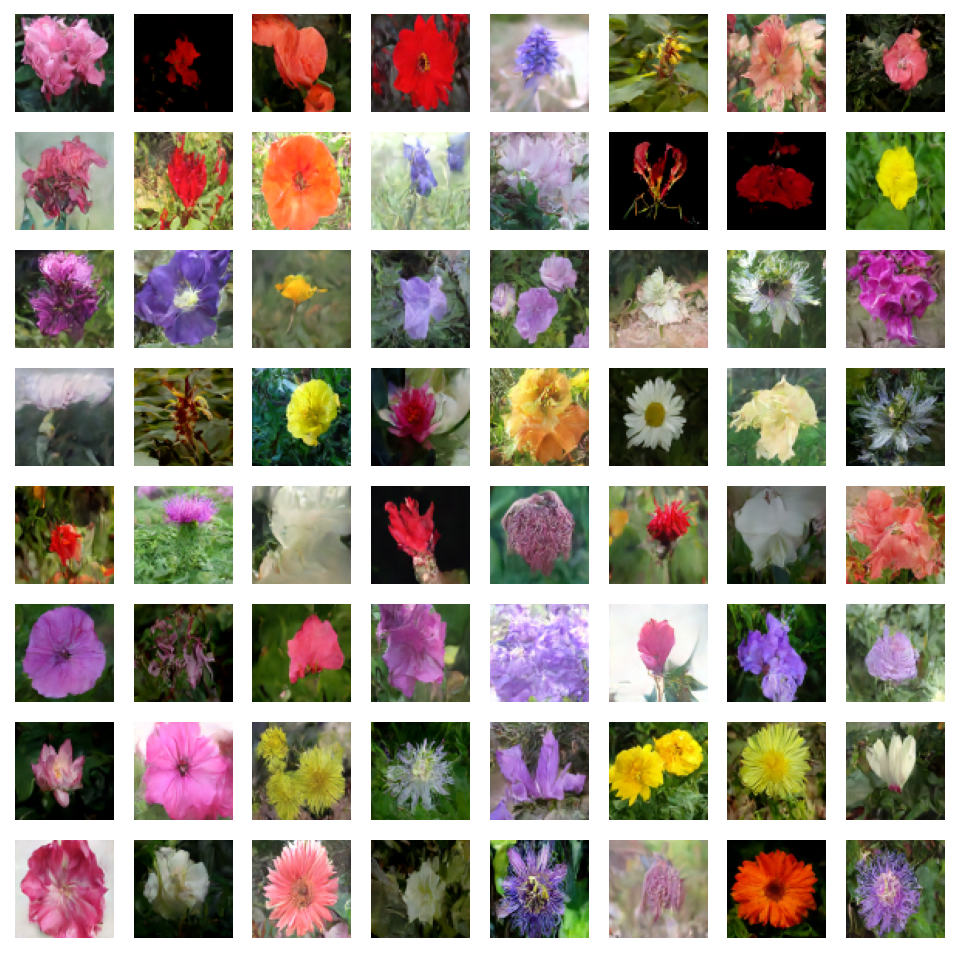

In [33]:
sampler = DDPMSampler(trainer.model, trainer.state.ema_params, cosine_schedule, model_output_transform=EpsilonPredictionTransform())
samples = sampler.generate_images(num_images=64, diffusion_steps=998, start_step=998, end_step=0, priors=None)
plotImages(samples, dpi=150)

An interesting thing about the SimpleDDPMSampler is that, unlike DDPMSampler where we need to take all the time steps to generate a sample, we can actually generate a sample in a fraction of the time steps as well, just like DDIMSampler. Don't ask me why, Its just something I realized after I implemented the simplified equations I derived on the backside of some bills.

In [34]:
class SimpleDDPMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        # Compute noise rates and signal rates only once
        current_signal_rate, current_noise_rate = self.noise_schedule.get_rates(current_step)
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        
        pred_noise_coeff = ((next_noise_rate ** 2) * current_signal_rate) / (current_noise_rate * next_signal_rate)
        
        noise_ratio_squared = (next_noise_rate ** 2) / (current_noise_rate ** 2)
        signal_ratio_squared = (current_signal_rate ** 2) / (next_signal_rate ** 2)
        gamma = jnp.sqrt(noise_ratio_squared * (1 - signal_ratio_squared))
        
        next_samples = next_signal_rate * reconstructed_samples + pred_noise_coeff * pred_noise + noise * gamma
        return next_samples, state

100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


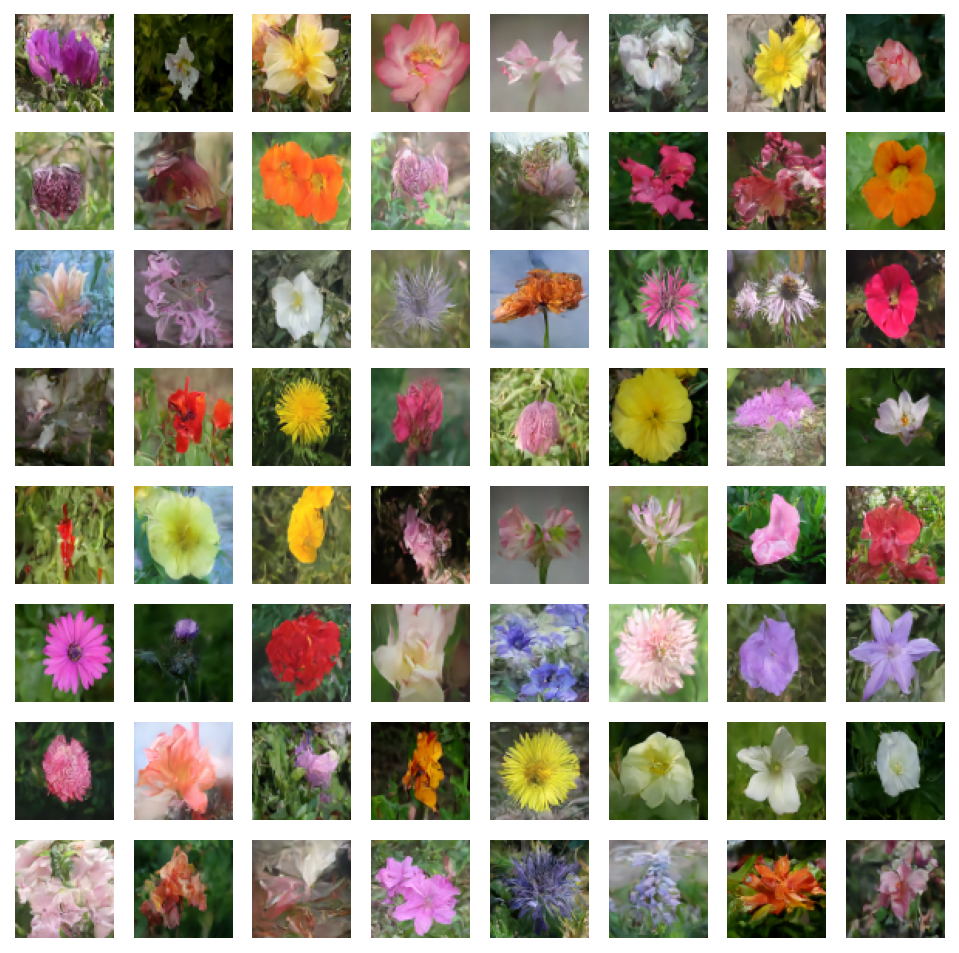

In [35]:
sampler = SimpleDDPMSampler(trainer.model, trainer.state.ema_params, cosine_schedule, model_output_transform=EpsilonPredictionTransform())
samples = sampler.generate_images(num_images=64, diffusion_steps=100, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=150)

## The Heun Sampler for ODEs

We have already looked at the Euler Sampler above. Even with the simple case of integrating for acceleration, we saw that the euler method was not perfect and the approximation was not very accurate. I said then that we could use more advanced methods to increase the accuracy, well Heun is one such method. Heun's method is a second order solver, and below we use it to solve the ODE probability flow of the reverse diffusion process. If you look at the code and try compare it with Euler Sampler, you would realize the similarities. Its basically taking a euler step, then making a new prediction on that step, then taking the average of the two predictions as the final output of the overall step. Thus Heun would actually do 2 model predictions on every step, but in reality it justifies itself with the faster convergence and quality. Heun's method can generate samples in 6-10 samples as compared to ~50 samples of Euler (20 model evals vs 50).

In [36]:
class HeunSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / dt

        dx_0 = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples_0 = current_samples + dx_0 * dt
        
        # Recompute x_0 and eps at the first estimate to refine the derivative
        state, rng = state.get_random_key()
        c_in = self.model_output_transform.get_input_scale((next_alpha, next_sigma))
        model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(next_samples_0*c_in, next_step))
        estimated_x_0, _ = self.model_output_transform(next_samples_0, model_output, next_step, self.noise_schedule)
        estimated_x_0 = clip_images(estimated_x_0)
        # Estimate the refined derivative using the midpoint (Heun's method)
        dx_1 = (next_samples_0 - x_0_coeff * estimated_x_0) / next_sigma
        # Compute the final next samples by averaging the initial and refined derivatives
        final_next_samples = current_samples + 0.5 * (dx_0 + dx_1) * dt
        
        return final_next_samples, state

    def generate_images(self, num_images=16, diffusion_steps=1000, start_step: int = None, *args, **kwargs):
        return super().generate_images(num_images=num_images, diffusion_steps=diffusion_steps, start_step=start_step, *args, **kwargs)


100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


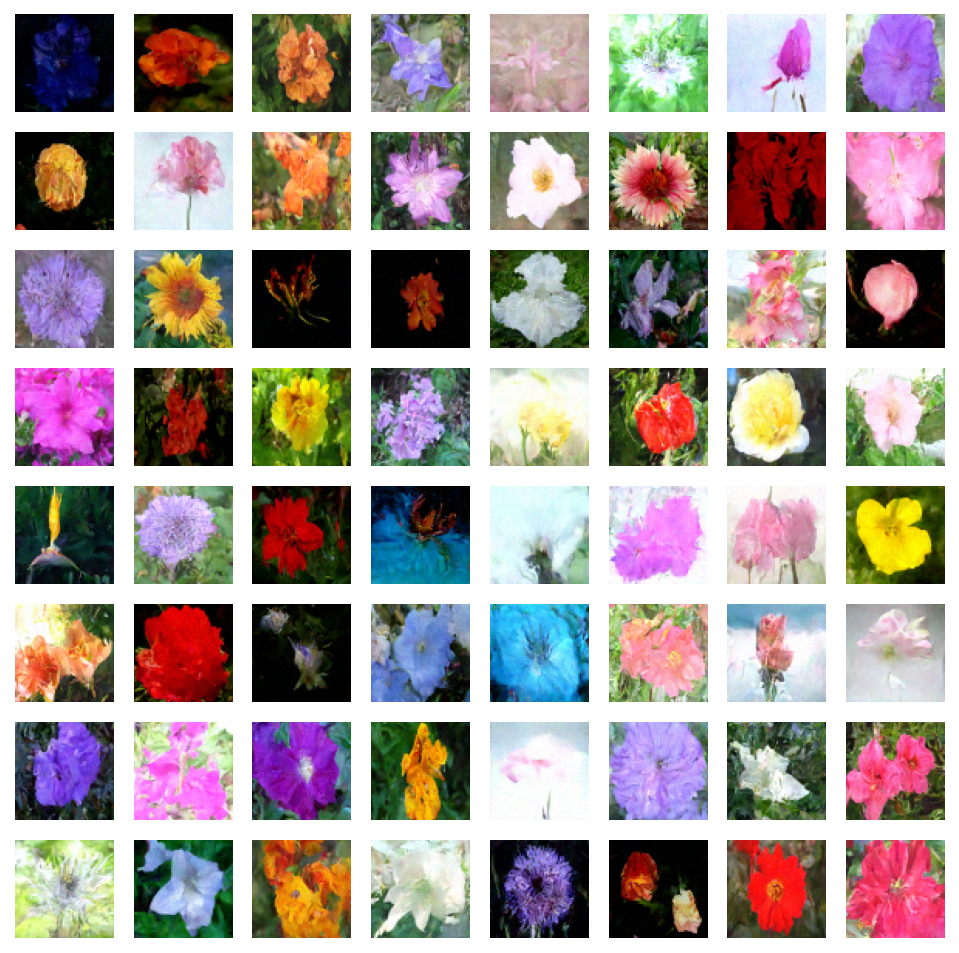

In [37]:
sampler = HeunSampler(trainer.model, trainer.state.ema_params, cosine_schedule, model_output_transform=EpsilonPredictionTransform())
samples = sampler.generate_images(num_images=64, diffusion_steps=20, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=150)